<a href="https://colab.research.google.com/github/marianadc01/pml-bone-fracture/blob/main/pml_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libriaries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import torch
from torch.utils.data import DataLoader
from torch.utils.data._utils.collate import default_collate
from torchvision import transforms, datasets
from torch import nn
from torch.optim import Adam
from torchvision import models

from sklearn.metrics import classification_report, confusion_matrix
import os
import shutil
from PIL import Image, ImageFile

In [ ]:
# Enable loading of truncated (corrupted) images

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
# Define the device

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set the directories for train, validation and test datasets

input_directory = '/content/drive/MyDrive/PML_2024/Bone_Fracture_Binary_Classification'
output_directory = '/content/working'
dataset_directory = f'{output_directory}/dataset'
output_train_directory = f'{dataset_directory}/train'
output_dev_directory = f'{dataset_directory}/val'
output_test_directory = f'{dataset_directory}/test'

In [ ]:
def removeCorruptFiles(directory_path):
  for item in os.listdir(directory_path):
    item_path = os.path.join(directory_path, item)

    if os.path.isdir(item_path):
      removeCorruptFiles(item_path)
    else:
      try:
        Image.open(item_path).verify()
      except (IOError, SyntaxError):
        os.remove(item_path)
        print(f'Removed corrupted image: {item}')

  # print("Corrupted image removal complete.")

In [ ]:
def removeEmptySubdirectories(directory):
    # Iterate over each entry in the directory
    for entry in os.listdir(directory):
        # Create full path
        full_path = os.path.join(directory, entry)

        # If entry is a directory, recursively remove empty subdirectories
        if os.path.isdir(full_path):
            removeEmptySubdirectories(full_path)

            # Check if directory is empty after removal
            if not os.listdir(full_path):
                # Remove the directory if it's empty
                os.rmdir(full_path)
                print(f"Removed empty directory: {full_path}")

In [ ]:
def copyDatasetIntoWorkingDir(source_directory, destination_directory):
    # Remove the destination directory if it already exists
    if os.path.exists(destination_directory):
        shutil.rmtree(destination_directory)


    shutil.copytree(source_directory, destination_directory)

In [ ]:
# Copy the database to perform changes on the images

copyDatasetIntoWorkingDir(input_directory, dataset_directory)

In [ ]:
# Remove corrupted images

removeCorruptFiles(output_train_directory)
removeCorruptFiles(output_dev_directory)
removeCorruptFiles(output_test_directory)

In [ ]:
# Define data transformation and augmentation methods

imgSize = 128

train_transform = transforms.Compose([
    transforms.Resize((imgSize, imgSize)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-10, 10)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])

])

val_transform = transforms.Compose([
    transforms.Resize((imgSize, imgSize)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])

])

test_transform = transforms.Compose([
    transforms.Resize((imgSize, imgSize)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])

])

In [ ]:
# Load the datasets and perform data transformation

train = datasets.ImageFolder(root="/content/working/dataset/train", transform=train_transform)
validation = datasets.ImageFolder(root="/content/working/dataset/val", transform=val_transform)
test = datasets.ImageFolder(root="/content/working/dataset/test", transform=test_transform)

In [ ]:
# Check amount of images in the datasets

print("Dataset Labels:\n", train.class_to_idx, "\n")

for name, dataset in zip(["TRAIN", "VALIDATION", "TEST"], [train, validation, test]):
    images_per_class = pd.Series(dataset.targets).value_counts()
    print(f"Images per Class in {name}:")
    print(images_per_class, "\n")

Dataset Labels:
 {'fractured': 0, 'not fractured': 1} 

Images per Class in TRAIN:
1    4650
0    4606
Name: count, dtype: int64 

Images per Class in VALIDATION:
1    492
0    337
Name: count, dtype: int64 

Images per Class in TEST:
1    268
0    238
Name: count, dtype: int64 



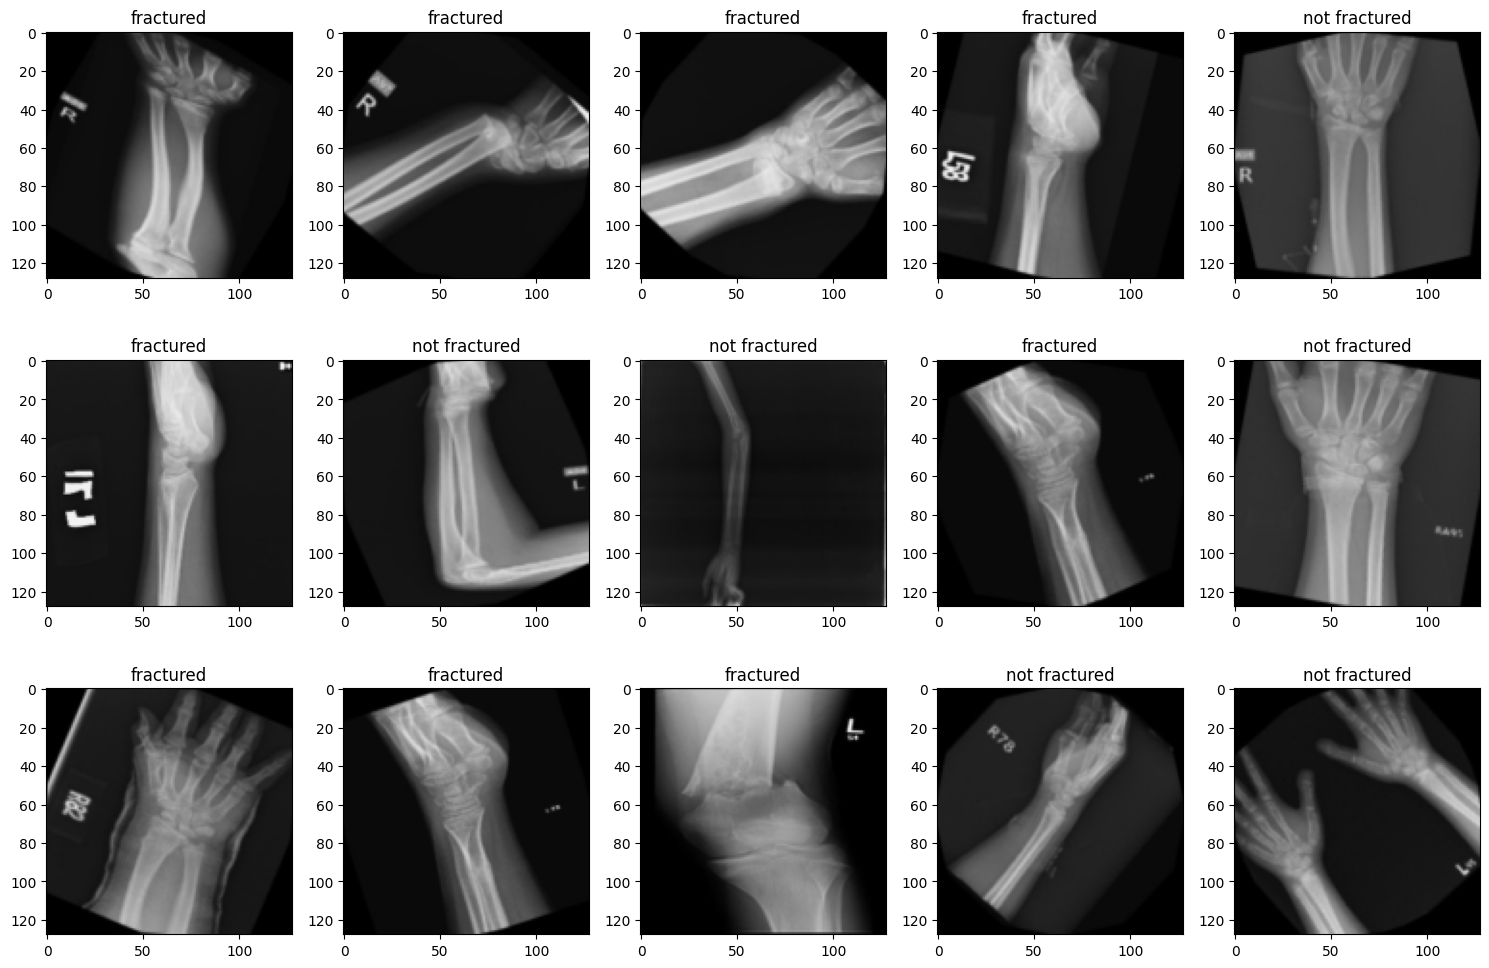

In [ ]:
# plot images before data augmentation

visualization_transform = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.ToTensor(),
])

visualization_dataset = datasets.ImageFolder(root="/content/working/dataset/train", transform=visualization_transform)

labels_for_viz = {v: k for k, v in train.class_to_idx.items()}

fig, ax = plt.subplots(3, 5, figsize=(15, 10))
ax = ax.flatten()
for i in range(15):
    sample = random.randint(0, len(visualization_dataset) - 1)
    image, label = visualization_dataset[sample]
    ax[i].imshow(image.permute(1, 2, 0))
    ax[i].title.set_text(labels_for_viz[label])
plt.tight_layout()
plt.show()

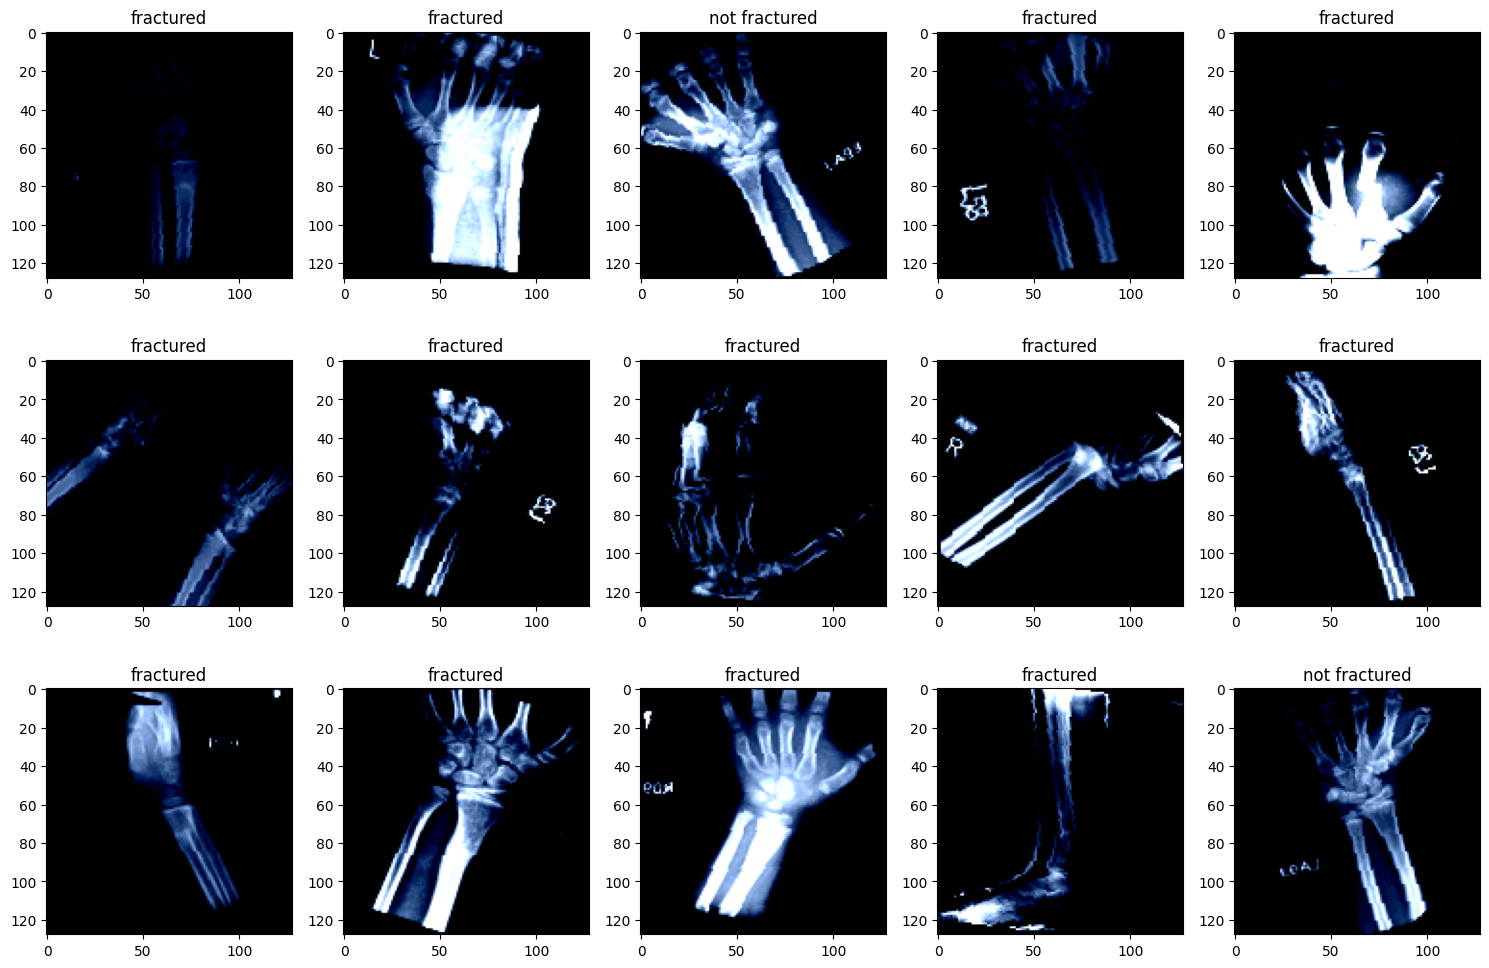

In [ ]:
# plot images after data augmentation

labels_for_viz = {v: k for k, v in train.class_to_idx.items()}

# Visualization of some training data
fig, ax = plt.subplots(3, 5, figsize=(15, 10))
ax = ax.flatten()
for i in range(15):
    sample = random.randint(0, len(train) - 1)
    ax[i].imshow(train[sample][0].permute(1, 2, 0))
    ax[i].title.set_text(labels_for_viz[train[sample][1]])
plt.tight_layout()
plt.show()

In [ ]:
def my_collate(batch):
    "Puts each data field into a tensor with outer dimension batch size"
    batch = list(filter(lambda x:x is not None, batch))
    return default_collate(batch)

In [ ]:
# Use DataLoader

batch_size = 16

train_dataloader = DataLoader(dataset=train,
                             batch_size=batch_size,
                             num_workers=2,
                             shuffle=True,
                             collate_fn = my_collate)

val_dataloader = DataLoader(dataset=validation,
                             batch_size=batch_size,
                             num_workers=2,
                             shuffle=True,
                             collate_fn = my_collate)

test_dataloader = DataLoader(dataset=test,
                             batch_size=batch_size,
                             num_workers=2,
                             shuffle=False,
                             collate_fn = my_collate)

In [ ]:
# Define the Neural Network

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=131072, out_features=32), # in_features are selected based on the output that Flatten layer yields
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=4)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.fc(x)
        return x

In [ ]:
# Define the model

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(in_features=512, out_features=2)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Loss and optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [ ]:
def train_and_validate_model(num_epochs):
    val_best_accuracy = 0.0
    train_loss_history = []
    val_loss_history = []
    train_accuracy_history = []
    val_accuracy_history = []

    print("Training begins...")
    for epoch in range(1, num_epochs+1):
        running_train_loss = 0.0
        running_train_accuracy = 0.0
        train_total = 0
        running_val_accuracy = 0.0
        running_val_loss = 0.0
        val_total = 0

        model.train()

        # TRAINING LOOP
        for data in train_dataloader:
            inputs, outputs = data
            inputs, outputs = inputs.to(device), outputs.to(device)
            optimizer.zero_grad()
            predictions = model(inputs)
            train_loss = loss_fn(predictions, outputs)
            _, train_predicted = torch.max(predictions, 1)
            running_train_accuracy += (train_predicted == outputs).sum().item()
            train_total += outputs.size(0)
            train_loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            running_train_loss += train_loss.item()

        train_loss_value = running_train_loss/len(train_dataloader)
        train_loss_history.append(train_loss_value)
        train_accuracy = (100*running_train_accuracy)/train_total
        train_accuracy_history.append(train_accuracy)

        # VALIDATION LOOP
        with torch.no_grad():
            model.eval()
            for data in val_dataloader:
                inputs, outputs = data
                inputs, outputs = inputs.to(device), outputs.to(device)
                predictions = model(inputs)
                val_loss = loss_fn(predictions, outputs)

                _, val_predicted = torch.max(predictions, 1)
                running_val_loss += val_loss.item()
                val_total += outputs.size(0)
                running_val_accuracy += (val_predicted == outputs).sum().item()

        val_loss_value = running_val_loss/len(val_dataloader)
        val_loss_history.append(val_loss_value)
        val_accuracy = (100*running_val_accuracy)/val_total
        val_accuracy_history.append(val_accuracy)

        if val_accuracy > val_best_accuracy:
            torch.save(model.state_dict(), "model.pth")
            val_best_accuracy = val_accuracy

        print("Completed Epoch: ", epoch, "- Training Accuracy: %d" %train_accuracy, "- Validation Accuracy: %d" %val_accuracy, "- Training Loss: %.4f" %train_loss_value, "- Validation Loss: %.4f" %val_loss_value)
    return train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history

In [ ]:
def test_model():
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(in_features=512, out_features=2)
    model = model.to(device)
    path = "model.pth"
    model.load_state_dict(torch.load(path))
    model.eval()

    running_accuracy = 0
    total = 0
    all_predictions = []

    with torch.no_grad():
        for data in test_dataloader:
            inputs, outputs = data
            inputs, outputs = inputs.to(device), outputs.to(device)
            outputs = outputs.to(torch.float32)
            predictions = model(inputs)
            _, predicted = torch.max(predictions, 1)
            total += outputs.size(0)
            running_accuracy += (predicted == outputs).sum().item()
            accuracy = 100*running_accuracy/total

            all_predictions.append(list(predicted.to("cpu").numpy()))
        print("Test Accuracy: ", accuracy)
    return np.hstack(all_predictions) # returns a flattened array of batches of predictions

In [ ]:
# Start training

EPOCHS = 20
train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history = train_and_validate_model(EPOCHS)
print("Training finished...\n")
all_preds = test_model()

Training begins...


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Completed Epoch:  1 - Training Accuracy: 81 - Validation Accuracy: 82 - Training Loss: 0.4377 - Validation Loss: 0.4058


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Completed Epoch:  2 - Training Accuracy: 83 - Validation Accuracy: 83 - Training Loss: 0.4066 - Validation Loss: 0.3821


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Completed Epoch:  3 - Training Accuracy: 84 - Validation Accuracy: 85 - Training Loss: 0.3855 - Validation Loss: 0.3637


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Completed Epoch:  4 - Training Accuracy: 86 - Validation Accuracy: 86 - Training Loss: 0.3558 - Validation Loss: 0.3386


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Completed Epoch:  5 - Training Accuracy: 87 - Validation Accuracy: 87 - Training Loss: 0.3318 - Validation Loss: 0.3104


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Completed Epoch:  6 - Training Accuracy: 88 - Validation Accuracy: 89 - Training Loss: 0.3169 - Validation Loss: 0.2936


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Completed Epoch:  7 - Training Accuracy: 88 - Validation Accuracy: 88 - Training Loss: 0.2956 - Validation Loss: 0.2806


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Completed Epoch:  8 - Training Accuracy: 90 - Validation Accuracy: 92 - Training Loss: 0.2723 - Validation Loss: 0.2552


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Completed Epoch:  9 - Training Accuracy: 90 - Validation Accuracy: 91 - Training Loss: 0.2538 - Validation Loss: 0.2507


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Completed Epoch:  10 - Training Accuracy: 91 - Validation Accuracy: 91 - Training Loss: 0.2397 - Validation Loss: 0.2352


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Completed Epoch:  11 - Training Accuracy: 91 - Validation Accuracy: 93 - Training Loss: 0.2282 - Validation Loss: 0.2112


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Completed Epoch:  12 - Training Accuracy: 92 - Validation Accuracy: 92 - Training Loss: 0.2130 - Validation Loss: 0.2067


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Completed Epoch:  13 - Training Accuracy: 92 - Validation Accuracy: 93 - Training Loss: 0.2024 - Validation Loss: 0.1978


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Completed Epoch:  14 - Training Accuracy: 93 - Validation Accuracy: 93 - Training Loss: 0.1824 - Validation Loss: 0.2016


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Completed Epoch:  15 - Training Accuracy: 93 - Validation Accuracy: 94 - Training Loss: 0.1730 - Validation Loss: 0.1812


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Completed Epoch:  16 - Training Accuracy: 94 - Validation Accuracy: 94 - Training Loss: 0.1555 - Validation Loss: 0.1638


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Completed Epoch:  17 - Training Accuracy: 94 - Validation Accuracy: 94 - Training Loss: 0.1564 - Validation Loss: 0.1646


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Completed Epoch:  18 - Training Accuracy: 94 - Validation Accuracy: 94 - Training Loss: 0.1422 - Validation Loss: 0.1659


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Completed Epoch:  19 - Training Accuracy: 95 - Validation Accuracy: 94 - Training Loss: 0.1277 - Validation Loss: 0.1462


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Completed Epoch:  20 - Training Accuracy: 95 - Validation Accuracy: 94 - Training Loss: 0.1227 - Validation Loss: 0.1515
Training finished...

Test Accuracy:  92.29249011857708


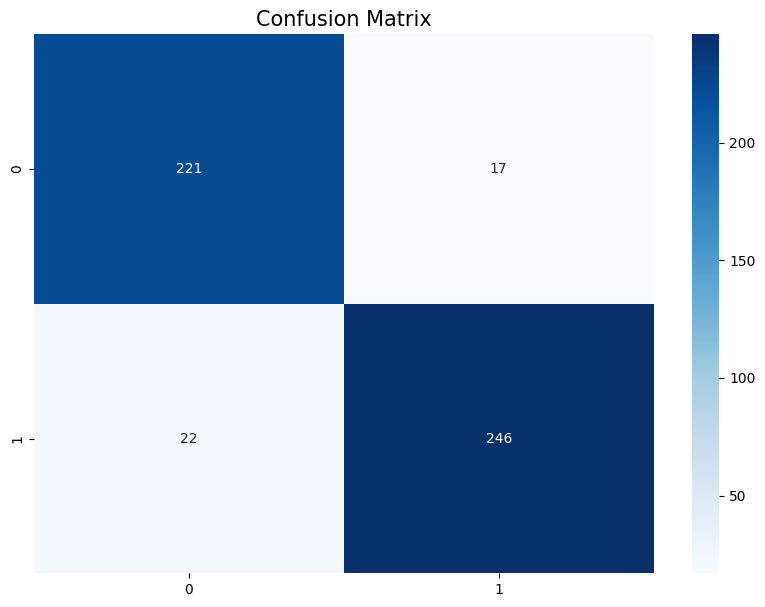

In [ ]:
def plot_confusion_matrix():

  plt.figure(figsize=(10, 7))
  sns.heatmap(confusion_matrix(test.targets, all_preds), cmap="Blues", annot=True, fmt="d")
  plt.title("Confusion Matrix", size=15)
  plt.show()

plot_confusion_matrix()

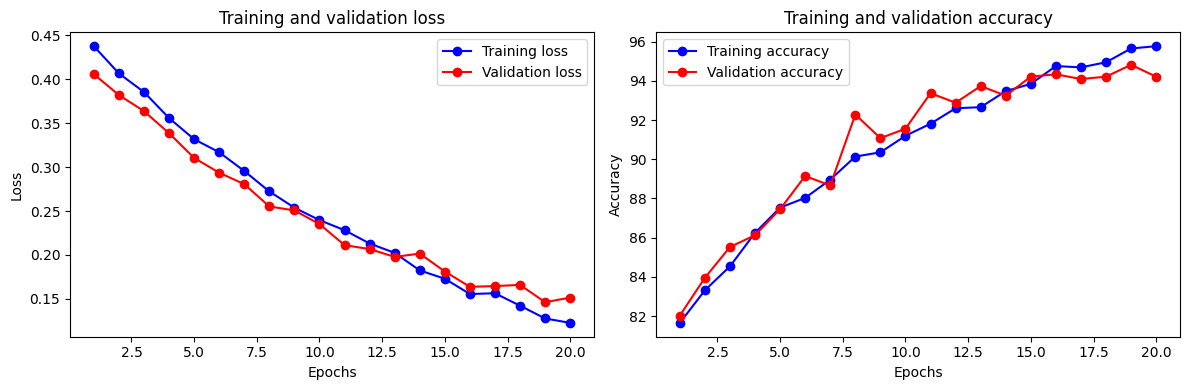

In [ ]:
def plot_learning_curves(train_loss, val_loss, train_accuracy, val_accuracy):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 4))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_learning_curves(train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history)